In [126]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,datasets
from torchvision.utils import make_grid as grid_creation
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt
import numpy as np
import math
import os

In [127]:
IMAGE_DIM = 64
BATCH_SIZE = 128
NOISE_DIM = 100
NUM_EPOCHS = 400
T_STEPS = 1000
ALPHA = 5e-5

In [128]:
PATH = "./"

In [129]:
transform = transforms.Compose([
            transforms.Resize((IMAGE_DIM,IMAGE_DIM)),
            transforms.CenterCrop(IMAGE_DIM),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
            ])
trainset = datasets.CIFAR10(PATH, train=True, download=True,
                                                       transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2)

#testset = datasets.CIFAR10(root=PATH, train=False,
#                                       download=True, transform=transform)
#testloader = DataLoader(testset, batch_size=BATCH_SIZE,shuffle=False, drop_last=True, num_workers=2)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

Files already downloaded and verified
cuda


In [130]:
def beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

betas = beta_schedule(T_STEPS)

In [131]:
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

In [132]:
class PositionEmbeds(nn.Module):
    def __init__(self, dim):
        super(PositionEmbeds, self).__init__()
        self.dim = dim
        self.dim_half = self.dim // 2

    def forward(self, time):
        embeds_exp = torch.exp(torch.arange(self.dim_half, device=device) * -1 * (math.log(10000) / (self.dim_half - 1)))
        embeds_time = time[:, None] * embeds_exp[None, :]
        embeds_time_sin_cos = torch.cat((embeds_time.sin(), embeds_time.cos()), dim=-1)
        return embeds_time_sin_cos

class DownSampleBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super(DownSampleBlock, self).__init__()
        self.time_nn =  nn.Linear(time_embed_dim, out_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu_activation  = nn.ReLU()
        self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        
    def forward(self, x, t):
        time_embed = self.relu_activation(self.time_nn(t))[(..., ) + (None, ) * 2] #add 2 dims at last
        h = self.bnorm1(self.relu_activation(self.conv1(x)))
        h = h + time_embed
        h = self.bnorm2(self.relu_activation(self.conv2(h)))
        out = self.transform(h)
        return out

class UpSampleBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super(UpSampleBlock, self).__init__()
        self.time_nn =  nn.Linear(time_embed_dim, out_ch)
        self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu_activation  = nn.ReLU()
        self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        
    def forward(self, x, t):
        time_embed = self.relu_activation(self.time_nn(t))[(..., ) + (None, ) * 2] #add 2 dims at last
        h = self.bnorm1(self.relu_activation(self.conv1(x)))
        h = h + time_embed
        h = self.bnorm2(self.relu_activation(self.conv2(h)))
        out = self.transform(h)
        return out

class UNet_Thin(nn.Module):
    def __init__(self,in_channels=3,out_dim=1,time_embed_dims=32):
        super(UNet_Thin, self).__init__()
        self.downsample_channels_list = (64, 128, 256, 512)
        self.upsample_channels_list = (512, 256, 128, 64)

        self.time_seq = nn.Sequential(
                PositionEmbeds(time_embed_dims),
                nn.Linear(time_embed_dims, time_embed_dims),
                nn.ReLU())
        
        self.conv_init = nn.Conv2d(in_channels, self.downsample_channels_list[0], 3, padding=1)
        self.down_module_list = nn.ModuleList([DownSampleBlock(self.downsample_channels_list[i], self.downsample_channels_list[i+1], time_embed_dims) \
                    for i in range(len(self.downsample_channels_list)-1)])
        self.up_module_list = nn.ModuleList([UpSampleBlock(self.upsample_channels_list[i], self.upsample_channels_list[i+1], time_embed_dims) \
                    for i in range(len(self.upsample_channels_list)-1)])
        self.output = nn.Conv2d(self.upsample_channels_list[-1], 3, out_dim)

    def forward(self, x_in, t_in):
        t = self.time_seq(t_in)
        x = self.conv_init(x_in)
        residual_list = []
        for down_block in self.down_module_list:
            x = down_block(x, t)
            residual_list.append(x)
        for up_block in self.up_module_list:
            residual_x = residual_list.pop()
            x = torch.cat((x, residual_x), dim=1)           
            x = up_block(x, t)
        return self.output(x)



In [133]:
def get_idx_with_shape(values, t, req_shape):
    batch_size = t.shape[0]
    out = values.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(req_shape) - 1))).to(t.device)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

def forward_sample(x_0, t):
    noise = torch.randn_like(x_0)
    #print(noise.shape)
    sqrt_alphas_cumprod_t = get_idx_with_shape(sqrt_alphas_cumprod, t, x_0.shape)
    #print(sqrt_alphas_cumprod_t.shape)
    sqrt_one_alphas_cumprod_t = get_idx_with_shape(sqrt_one_alphas_cumprod, t, x_0.shape)
    #print(sqrt_one_alphas_cumprod_t.shape)
    return noise.to(device), sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_alphas_cumprod_t.to(device) * noise.to(device)

In [134]:
reverse_model = UNet_Thin()
reverse_model.to(device)
optimizer = torch.optim.Adam(reverse_model.parameters(), lr=ALPHA)

In [135]:
if not os.path.isfile(PATH+'diffusion_model.pth'):
    NUM_EPOCH_TO_PRINT_LOSS = 5
    reverse_model.train()
    for epoch in range(NUM_EPOCHS):
        for idx, batch in enumerate(trainloader):
            optimizer.zero_grad()

            x_0 = batch[0]
            t = torch.randint(0, T_STEPS, (BATCH_SIZE,), device=device).long()
            noise, x_after_noise = forward_sample(x_0, t)
            noise_pred = reverse_model(x_after_noise, t)
            
            loss = F.mse_loss(noise, noise_pred)
            loss.backward()
            optimizer.step()

        if epoch % NUM_EPOCH_TO_PRINT_LOSS == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
            

    model_dict = reverse_model.state_dict()
    opt_dict = optimizer.state_dict()
    save_dict = {'model_dict' : model_dict, 'opt_dict' : opt_dict}
    torch.save(save_dict, PATH+'diffusion_model.pth')
    print('Saved diffusion_model')

In [136]:
def tensor_to_image(tensor_image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])
    if len(tensor_image.shape) == 4:
        image = tensor_image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

loaded diffusion_model.pth


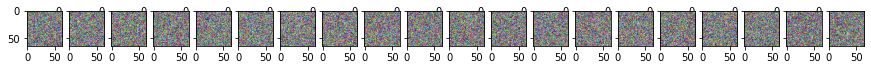

In [137]:
if os.path.isfile(PATH+'diffusion_model.pth'):
    load_dict = torch.load(PATH+'diffusion_model.pth')
    reverse_model.load_state_dict(load_dict['model_dict'])
    optimizer.load_state_dict(load_dict['opt_dict'])
    print("loaded diffusion_model.pth")

    reverse_model.eval()

    sqrt_reciprocal_alphas = torch.sqrt(1.0 / alphas)
    alphas_cumprod_pad = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
    variance = betas * (1. - alphas_cumprod_pad) / (1. - alphas_cumprod)

    def timestep_sampling(model, x, t):
        with torch.no_grad():
            betas_t = get_idx_with_shape(betas, t, x.shape)
            sqrt_one_alphas_cumprod_t = get_idx_with_shape(sqrt_one_alphas_cumprod, t, x.shape)
            sqrt_recip_alphas_t = get_idx_with_shape(sqrt_reciprocal_alphas, t, x.shape)
            mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_alphas_cumprod_t)
            variance_t = get_idx_with_shape(variance, t, x.shape)
              
            if t == 0:
                return mean
            else:
                noise = torch.randn_like(x)
                return mean + torch.sqrt(variance_t) * noise 

    def test(model):
        img = torch.randn((1, 3, IMAGE_DIM, IMAGE_DIM), device=device)
        plt.figure(figsize=(15,15))
        plt.axis('off')
        num_images = 20
        step = int(T_STEPS/num_images)

        for idx in range(0,T_STEPS)[::-1]:
            t = torch.full((1,), idx, device=device, dtype=torch.long)
            img = timestep_sampling(model, img, t)
            if idx % step == 0:
                plt.subplot(1, num_images, idx/step+1)
                tensor_to_image(img.detach().cpu())
        plt.show()

    test(reverse_model)